In [4]:
import datetime
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from IPython.display import clear_output
import tensorflow as tf
from tensorflow.keras.preprocessing.image import array_to_img
from tensorflow.keras.layers import Conv2D, DepthwiseConv2D, BatchNormalization, Input, Concatenate, UpSampling2D
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras.backend import binary_crossentropy as bce
from tensorflow.keras.backend import flatten
from tensorflow.data.experimental import AUTOTUNE
from tensorflow.nn import relu6
from tensorflow.math import sigmoid
from tensorflow.keras.optimizers import Adam

In [3]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [13]:
TRAIN_LENGTH = 256
BATCH_SIZE = 16
BUFFER_SIZE = 1000
STEPS_PER_EPOCH = TRAIN_LENGTH// BATCH_SIZE
EPOCHS = 200
VALIDATION_STEPS = 29 // BATCH_SIZE
IMAGE_HEIGHT = 544
IMAGE_WIDTH = IMAGE_HEIGHT

In [40]:
def display(display_list):
    plt.figure(figsize=(15, 15))
    plt.subplot(1, len(display_list), 1)
    plt.imshow(array_to_img(display_list[0]))
    plt.axis('off')
    plt.subplot(1, len(display_list), 2)
    plt.imshow(array_to_img(display_list[1]), cmap='gray')
    plt.axis('off')
    plt.show()

In [41]:
@tf.function
def training_process_path(file_path):
    image = tf.io.read_file(file_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, (IMAGE_HEIGHT, IMAGE_WIDTH)) 
    image = tf.image.convert_image_dtype(image, tf.float32) 
    image = tf.image.random_saturation(image, 0.98, 1.02)
    image = tf.image.random_contrast(image, 0.7, 1.3)
    image = tf.image.random_hue(image, 0, 0.02)
    image = tf.math.divide(tf.subtract( image, tf.reduce_min(image)), tf.subtract(tf.reduce_max(image), tf.reduce_min(image)))
    
    mask_path = tf.strings.regex_replace(file_path, "image", "mask")
    mask_path = tf.strings.regex_replace(mask_path, "jpg", "png")
    mask = tf.io.read_file(mask_path)
    mask = tf.image.decode_png(mask, channels=1)
    mask = tf.image.resize(mask, (IMAGE_HEIGHT, IMAGE_WIDTH), method = 'nearest')
    mask = tf.image.convert_image_dtype(mask, tf.uint8) / 255
    if tf.random.uniform(()) > 0.5:
        image = tf.image.flip_left_right(image)
        mask = tf.image.flip_left_right(mask)
    if tf.random.uniform(()) > 0.5:
        image = tf.image.flip_up_down(image)
        mask = tf.image.flip_up_down(mask)

    return image, mask

In [42]:
training_path = tf.data.Dataset.list_files(str('dataset/training/image/*'))
training_dat = training_path.take(TRAIN_LENGTH).cache().shuffle(BUFFER_SIZE)
training_dat = training_dat.map(training_process_path, num_parallel_calls=AUTOTUNE).batch(BATCH_SIZE).repeat()
training_dat = training_dat.prefetch(buffer_size=AUTOTUNE)

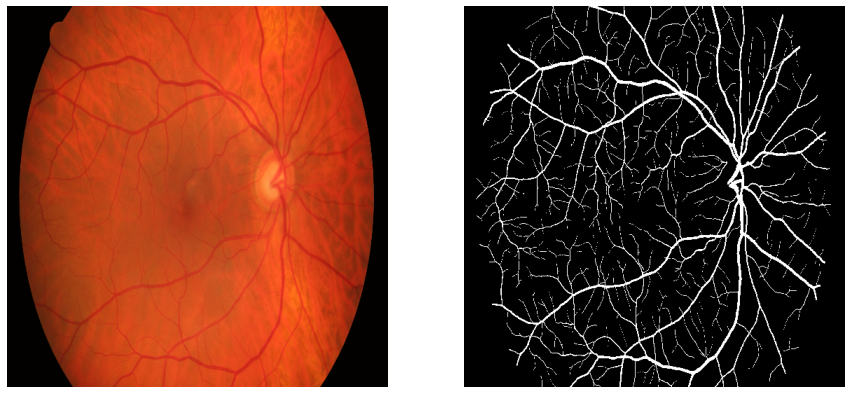

In [67]:
sample_image, sample_mask = next(iter(training_dat))
display([sample_image[0], sample_mask[0]])

In [11]:
@tf.function
def testing_process_path(file_path):
    image = tf.io.read_file(file_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, (IMAGE_HEIGHT, IMAGE_WIDTH)) 
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = tf.math.divide(tf.subtract( image, tf.reduce_min(image)), tf.subtract(tf.reduce_max(image), tf.reduce_min(image)))
    
    mask_path = tf.strings.regex_replace(file_path, "image", "mask")
    mask_path = tf.strings.regex_replace(mask_path, "jpg", "png")
    mask = tf.io.read_file(mask_path)
    mask = tf.image.decode_png(mask, channels=1)
    mask = tf.image.resize(mask, (IMAGE_HEIGHT, IMAGE_WIDTH), method = 'nearest')
    mask = tf.image.convert_image_dtype(mask, tf.uint8) / 255

    return image, mask

In [14]:
testing_path = tf.data.Dataset.list_files(str('dataset/testing/image/*.jpg'))
testing_ds = testing_path.map(testing_process_path, num_parallel_calls=AUTOTUNE)
testing_dat = testing_ds.batch(VALIDATION_STEPS).prefetch(VALIDATION_STEPS)

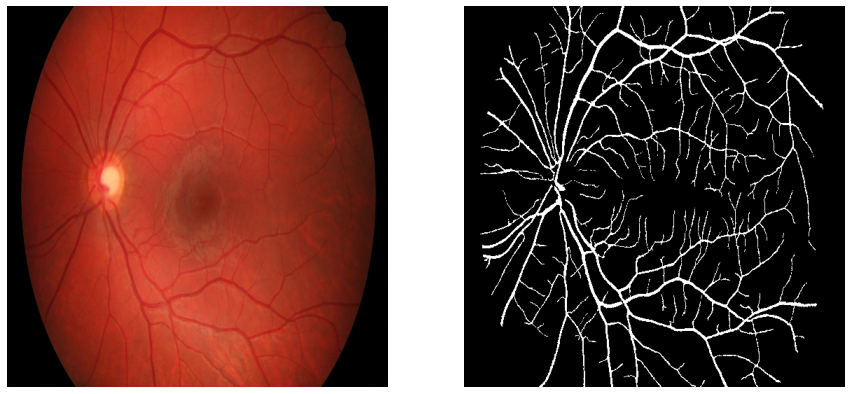

In [45]:
sample_image, sample_mask = next(iter(testing_dat))
display([sample_image[0], sample_mask[0]])

In [46]:
def Conv(inputs, filters, kernel, strides):
    x = Conv2D(filters, kernel, padding='same', strides=strides)(inputs)
    x = BatchNormalization()(x)
    return relu6(x)

In [47]:
def InvertedResidual(input_x, filters, strides, expansion_factor=6):
    input_channels = input_x.shape[-1]
    x = Conv2D(filters=int(input_channels*expansion_factor), padding='same', kernel_size=1, use_bias=False)(input_x)
    x = BatchNormalization()(x)
    x = relu6(x)

    x = DepthwiseConv2D(kernel_size=3, strides=strides, padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = relu6(x)

    x = Conv2D(filters=filters, padding='same', kernel_size=1, use_bias=False)(x)
    x = BatchNormalization()(x)

    if input_x.shape[1:] == x.shape[1:]:
        x += input_x
    return x

In [48]:
def Decode(up, x, out):
    upsample = UpSampling2D((2,2), interpolation='bilinear')(up)
    concat = Concatenate()([upsample, x])
    inv = InvertedResidual(concat, out, 1, 0.15)
    return inv

In [49]:
def M2UNet(input_shape):
    inputs = Input(shape=input_shape)
    conv = Conv(inputs, 32, (1,1), 2)
    inv16_1 = InvertedResidual(conv, 16, 1, 1)
    inv24_1 = InvertedResidual(inv16_1, 24, 2, 6)
    inv24_2 = InvertedResidual(inv24_1, 24, 1, 6)
    inv32_1 = InvertedResidual(inv24_2, 32, 2, 6)
    inv32_2 = InvertedResidual(inv32_1, 32, 1, 6)
    inv32_3 = InvertedResidual(inv32_2, 32, 1, 6)
    inv64_1 = InvertedResidual(inv32_3, 64, 2, 6)
    inv64_2 = InvertedResidual(inv64_1, 64, 1, 6)
    inv64_3 = InvertedResidual(inv64_2, 64, 1, 6)
    inv64_4 = InvertedResidual(inv64_3, 64, 1, 6)
    inv96_1 = InvertedResidual(inv64_4, 96, 1, 6)
    inv96_2 = InvertedResidual(inv96_1, 96, 1, 6)
    inv96_3 = InvertedResidual(inv96_2, 96, 1, 6)
    decode4 = Decode(inv96_3, inv32_3, 64)
    decode3 = Decode(decode4, inv24_2, 44)
    decode2 = Decode(decode3, inv16_1, 30)
    decode1 = Decode(decode2, inputs, 1)
    sigm = sigmoid(decode1)
    model = Model(inputs, sigm)
    return model

In [50]:
model = M2UNet((IMAGE_HEIGHT, IMAGE_WIDTH, 3))
#     model.summary()
# tf.keras.utils.plot_model(model, to_file='model.png', show_shapes=True)

In [9]:
@tf.function
def jaccard(y_true, y_pred):
    y_true = flatten(y_true)
    y_pred = flatten(y_pred)
    intersection = K.sum(K.abs(y_true * y_pred))
    sum_ = K.sum(K.abs(y_true) + K.abs(y_pred))
    jac = (intersection + 1e-6) / (sum_ - intersection + 1e-6)
    return 1 - jac

In [10]:
@tf.function
def custom_loss_func(y_true, y_pred):
    return 0.7 * bce(y_true, y_pred) + 0.3 * jaccard(y_true, y_pred)

In [7]:
optimizer = Adam(learning_rate=0.001)

In [33]:
model.compile(optimizer=optimizer,
              loss=custom_loss_func,
              metrics=['accuracy', dice_coeff])

In [8]:
def dice_coeff(y_true, y_pred):
    smooth = 1.
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    score = (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return score

In [0]:
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

In [ ]:
model.fit(training_dat, epochs=EPOCHS,
          steps_per_epoch=STEPS_PER_EPOCH,
          validation_steps=VALIDATION_STEPS,
          validation_data=testing_dat,
          callbacks=[tensorboard_callback])

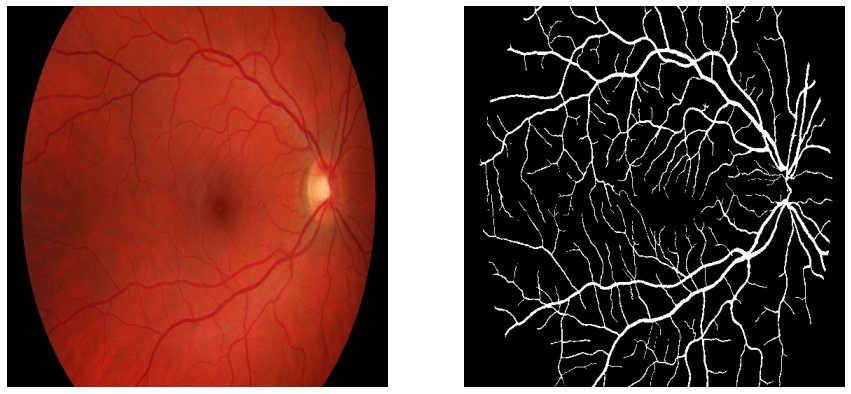

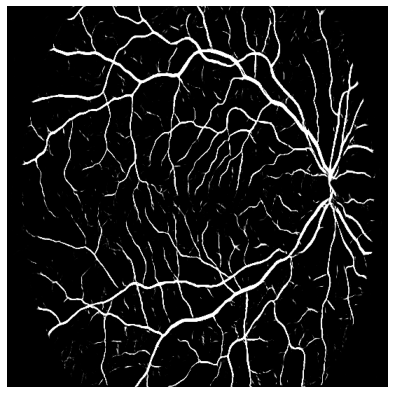

In [57]:
image, mask = next(iter(testing_dat))
pred_mask = reconstructed_model.predict(image)
display([image[0], mask[0]])
pred_array = np.array(array_to_img(pred_mask[0])).flatten() > 0.525
p = pred_mask.reshape(IMAGE_HEIGHT,IMAGE_WIDTH)
plt.figure(figsize=(7, 7))
plt.imshow(p, cmap='gray')
plt.axis('off')
plt.show()

In [58]:
model = tf.keras.models.load_model('model.h5', custom_objects={ 'loss': custom_loss_func }, compile = False)
model.compile(loss = custom_loss_func, optimizer = optimizer, metrics=[dice_coeff])